
# Data preparation
We combine the data, convert the labels for classification and apply augmentation

In [53]:
import os, sys, math, json
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(0)

IMAGE_SIZE = [32, 32]

In [54]:
df = pd.read_json('../data/labelled_data/prepared-samples-binary.json')

y = df['label'].to_numpy()
X = np.array(df['data'].to_list())
X = np.expand_dims(X, axis=3)
print(y.shape)
print(X.shape)

(200,)
(200, 32, 32, 1)


In [55]:
# Create train / val / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [56]:
# Simple CNN (sequential) Model

model = keras.Sequential(
    [
        keras.Input(shape=(32,32,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(2, activation="softmax"),
    ]
)

model.compile(
optimizer='adam',
loss= 'sparse_categorical_crossentropy',
metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 2304)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2304)             

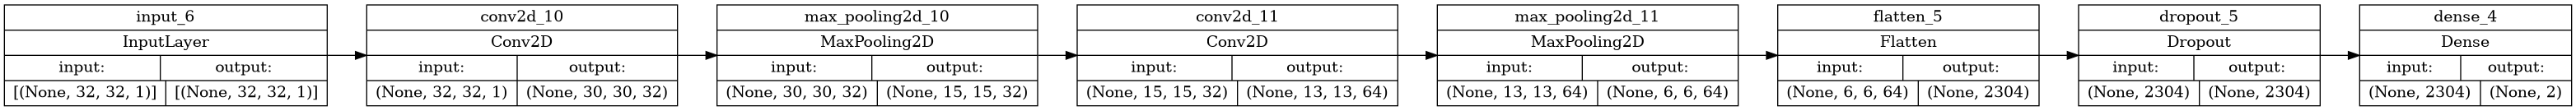

In [57]:
# Plot the model
# `rankdir='LR'` is to make the graph horizontal.
%matplotlib inline
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Epoch 1/100
8/8 [==============================] - 1s 69ms/step - loss: 1.2065 - accuracy: 0.5417 - val_loss: 0.7305 - val_accuracy: 0.3250
Epoch 2/100
8/8 [==============================] - 0s 48ms/step - loss: 0.8310 - accuracy: 0.5667 - val_loss: 0.6515 - val_accuracy: 0.6500
Epoch 3/100
8/8 [==============================] - 0s 36ms/step - loss: 0.7276 - accuracy: 0.5833 - val_loss: 0.6314 - val_accuracy: 0.7500
Epoch 4/100
8/8 [==============================] - 0s 30ms/step - loss: 0.6989 - accuracy: 0.5750 - val_loss: 0.6294 - val_accuracy: 0.6500
Epoch 5/100
8/8 [==============================] - 0s 34ms/step - loss: 0.6649 - accuracy: 0.5917 - val_loss: 0.6329 - val_accuracy: 0.7000
Epoch 6/100
8/8 [==============================] - 0s 34ms/step - loss: 0.6666 - accuracy: 0.6750 - val_loss: 0.6270 - val_accuracy: 0.6500
Epoch 7/100
8/8 [==============================] - 0s 38ms/step - loss: 0.6483 - accuracy: 0.6417 - val_loss: 0.6221 - val_accuracy: 0.6500
Epoch 8/100
8/8 [===

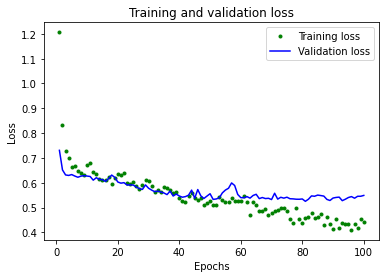

Test loss: 0.6240233778953552 / Test accuracy: 0.675000011920929


In [58]:
# Fit the model
EPOCHS = 50
BATCH_SIZE = 16
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("simpleCnn-sequential-eval.png")
plt.show()

# Generate generalization metrics
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [62]:


label = {1: 'Human',
         0: 'No Human'}

pred = model.predict(X_test)

classes = np.argmax(pred, axis = 1)
print(classes)

[1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1
 0 0 1]


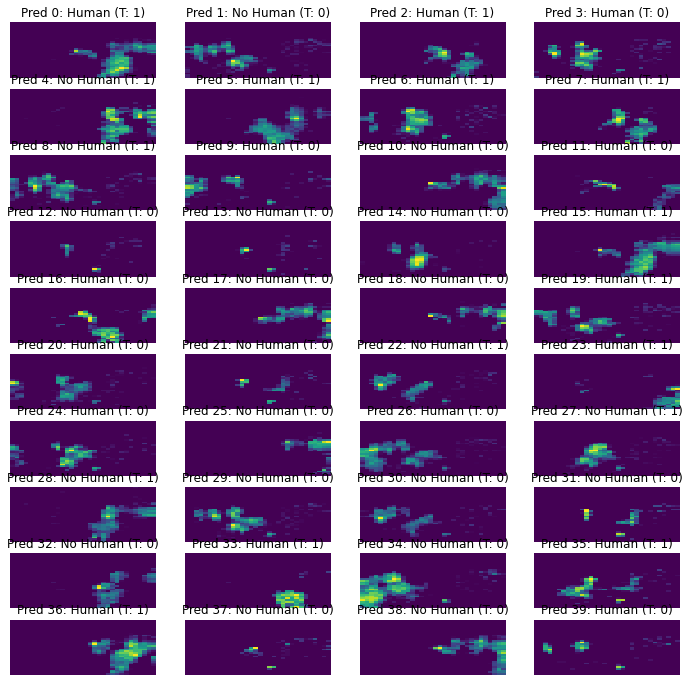

In [65]:
# Print predictions
%matplotlib inline
n=4 # pics per row

fig, axes = plt.subplots(nrows=int(len(X_test)/n), ncols=n, figsize=(n*3, n*3), num='Predictions')

for ax, idx in zip(axes.reshape(-1), range(len(X_test))): 
    ax.set_axis_off()
    ax.set_title('Pred %i: %s (T: %i)' % (idx, label[classes[idx]], y_test[idx]))
    ax.imshow(X_test[idx].reshape(32, 32), interpolation='nearest', aspect='auto')

In [61]:
# Export saved model
tf.keras.models.save_model(model, "simpleCnn-sequential-binary.h5")